In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
df.shape

(10000, 10)

## EDA

In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [28]:
df['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

<AxesSubplot:xlabel='Type', ylabel='count'>

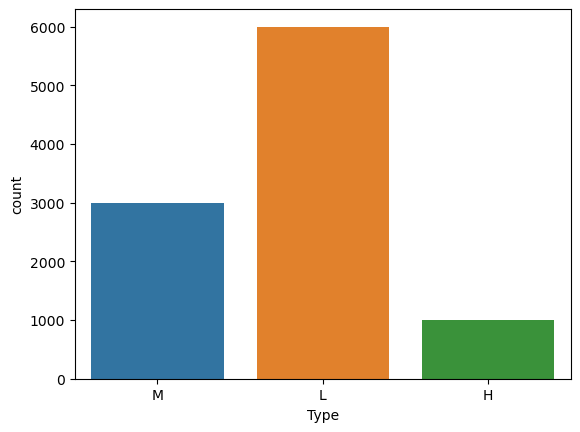

In [8]:
sns.countplot(df,x='Type')

<AxesSubplot:xlabel='Type', ylabel='count'>

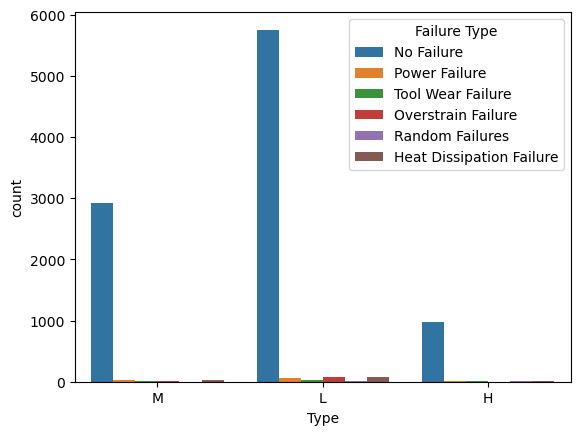

In [9]:
sns.countplot(df,x='Type',hue='Failure Type')

Text(0.5, 1.0, 'Distribution of Faliure Type')

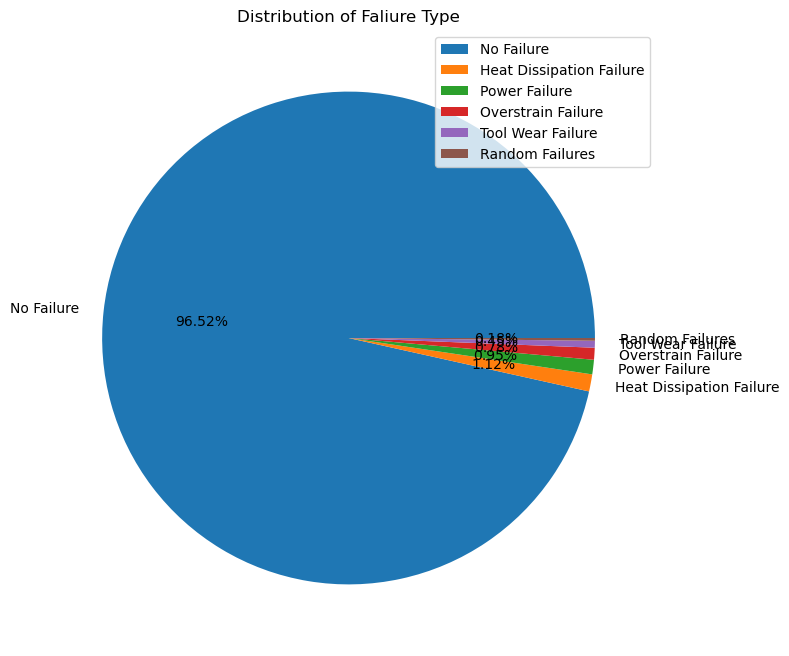

In [24]:
plt.figure(figsize=(9,8))
value=df['Failure Type'].value_counts()
plt.pie(x=value,labels=value.index,autopct='%0.2f%%')
plt.legend()
plt.title("Distribution of Faliure Type")

In [ ]:
# After seeing the pie chart ,the most of label are assigned to no failure ,so we need to handle imbalance data set

In [26]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [27]:
df['Target'].unique()

array([0, 1], dtype=int64)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'UDI'),
  Text(1, 0, 'Air temperature [K]'),
  Text(2, 0, 'Process temperature [K]'),
  Text(3, 0, 'Rotational speed [rpm]'),
  Text(4, 0, 'Torque [Nm]'),
  Text(5, 0, 'Tool wear [min]'),
  Text(6, 0, 'Target')])

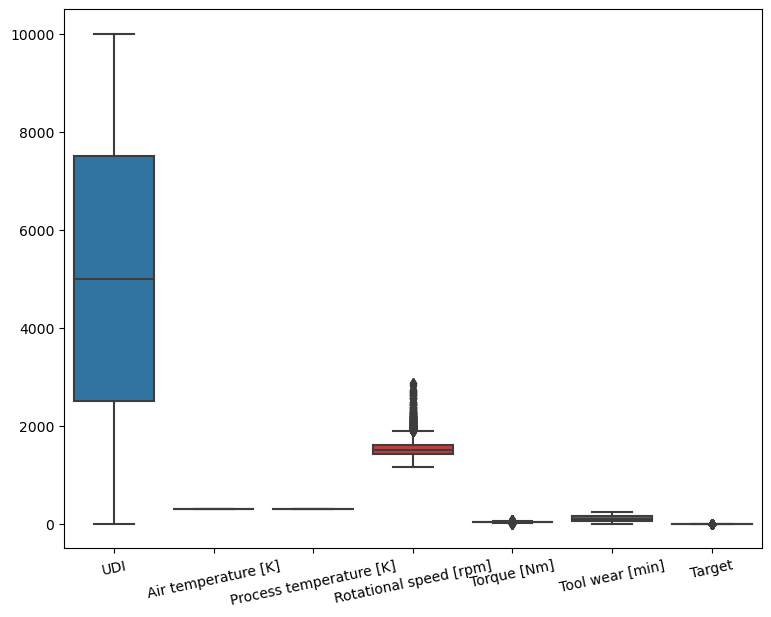

In [42]:
plt.figure(figsize=(9,7))
sns.boxplot(df)
plt.xticks(rotation=12)

<AxesSubplot:xlabel='Rotational speed [rpm]'>

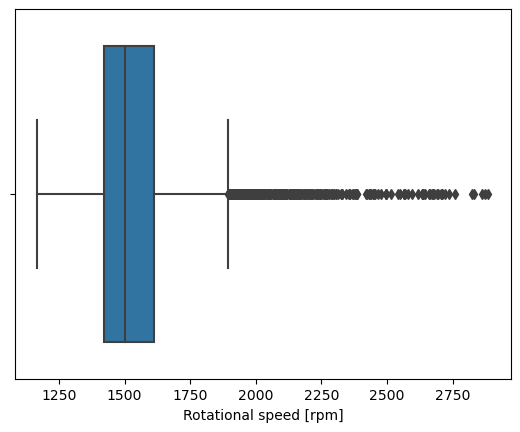

In [43]:
# checking the outlier
sns.boxplot(df,x='Rotational speed [rpm]')

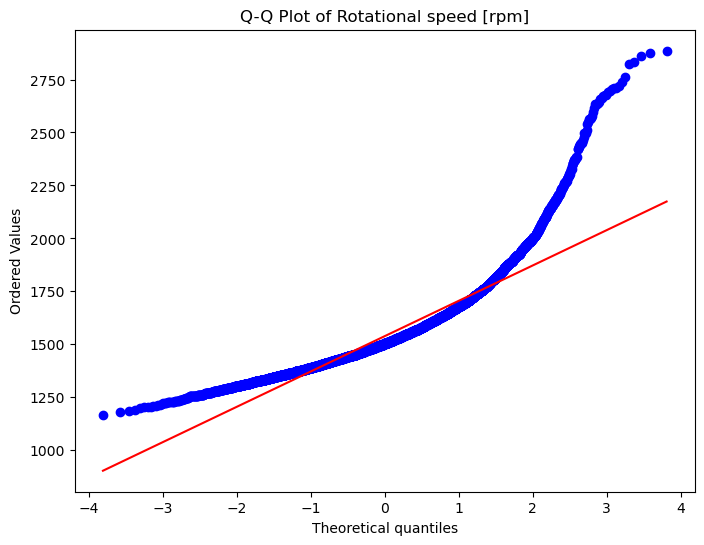

In [44]:
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(df['Rotational speed [rpm]'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Rotational speed [rpm]')
plt.show()

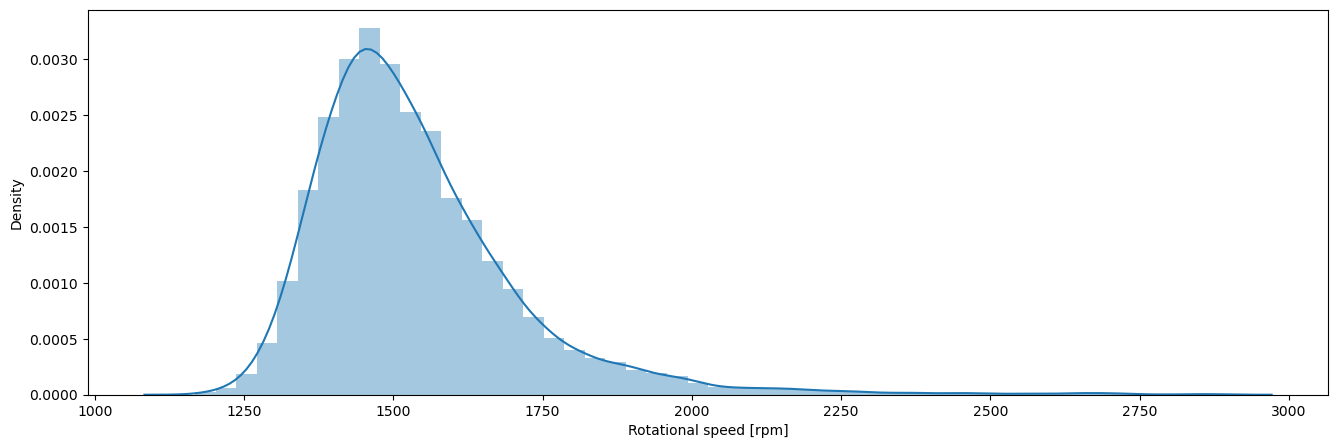

In [45]:
plt.figure(figsize=(16,5))
sns.distplot(df['Rotational speed [rpm]'])
plt.show()

In [3]:
q1 = df['Rotational speed [rpm]'].quantile(0.25)
q3 = df['Rotational speed [rpm]'].quantile(0.75)

iqr = q3 - q1

upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr
print(upper_limit)
print(lower_limit)



1895.5
1139.5


In [4]:
df.loc[df['Rotational speed [rpm]']>1895.5,'Rotational speed [rpm]']=1895.5

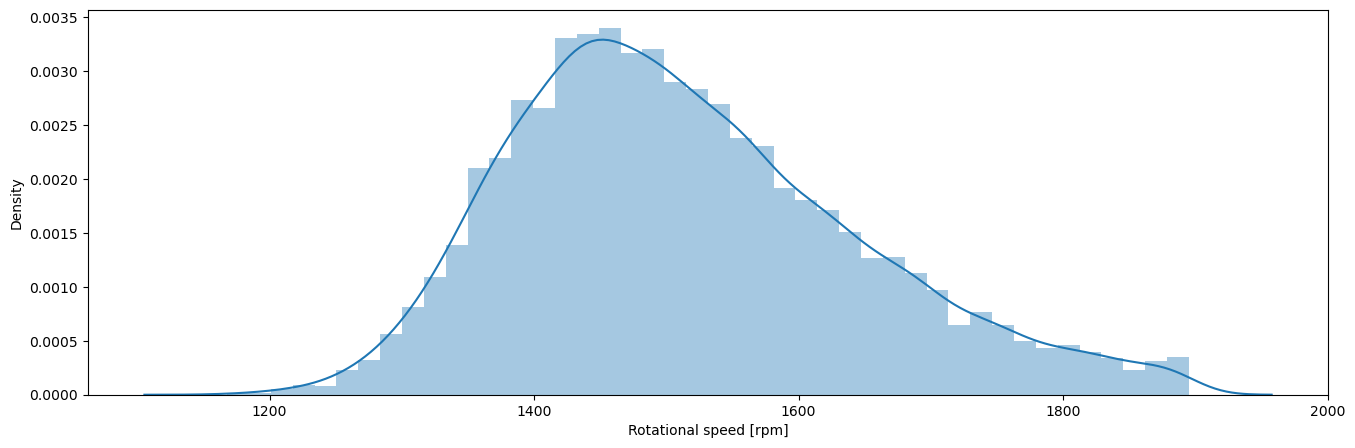

In [47]:
plt.figure(figsize=(16,5))
sns.distplot(df['Rotational speed [rpm]'])
plt.show()

<AxesSubplot:xlabel='Rotational speed [rpm]'>

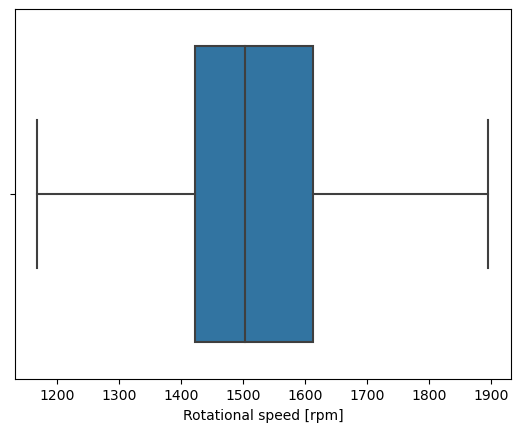

In [5]:
sns.boxplot(df,x='Rotational speed [rpm]')

<AxesSubplot:>

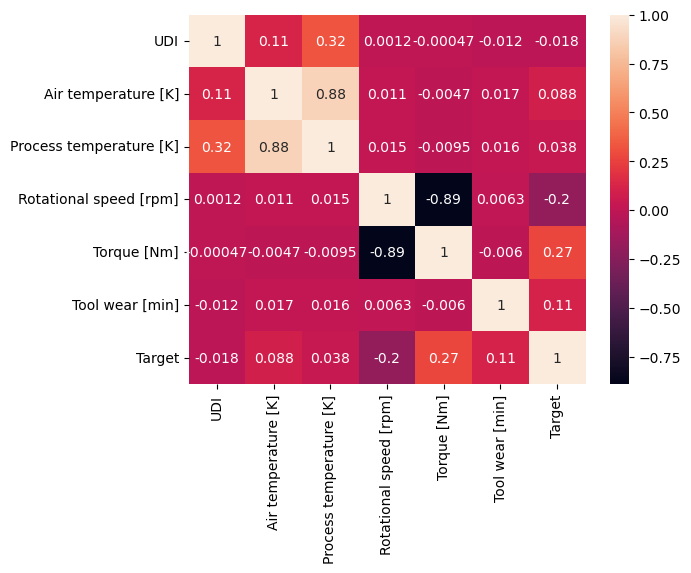

In [58]:
corr=df.corr()
sns.heatmap(corr,annot=True,cbar='coolwarm')


# Data preprocessing 

In [6]:
dic={'H':0,'M':1,'L':2}
df['Type']=df['Type'].map(dic)

In [7]:
#drop uncesscary columns
df=df.drop(['UDI','Product ID'],axis=1)

In [36]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,298.1,308.6,1551.0,42.8,0,0,No Failure
1,2,298.2,308.7,1408.0,46.3,3,0,No Failure
2,2,298.1,308.5,1498.0,49.4,5,0,No Failure
3,2,298.2,308.6,1433.0,39.5,7,0,No Failure
4,2,298.2,308.7,1408.0,40.0,9,0,No Failure


In [13]:
X=df[['Type','Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','orque [Nm]','Tool wear [min]']]
Y=df['Target']

In [17]:

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=42,test_size=0.20)

In [19]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
lb.fit(Y_train)

LabelEncoder()

In [20]:
y_train=lb.transform(Y_train)
y_test=lb.transform(Y_test)

In [32]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [33]:
pred=dt.predict(X_test)

In [37]:
print(accuracy_score(pred,y_test))

0.99


In [35]:
confusion_matrix(pred,y_test)

array([[  15,    0,    0,    0,    0,    0],
       [   0, 1930,    1,    3,    6,    0],
       [   0,    0,   11,    3,    0,    1],
       [   0,    1,    1,   14,    0,    0],
       [   0,    4,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   10]], dtype=int64)

In [39]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.99      1.00      1940
           2       0.85      0.73      0.79        15
           3       0.70      0.88      0.78        16
           4       0.00      0.00      0.00         4
           5       0.91      1.00      0.95        10

    accuracy                           0.99      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.99      0.99      0.99      2000



In [8]:
x=df[['Type','Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']]
y=df['Failure Type']

In [9]:
# with oversampling 
sm=SMOTE()
x_smote,y_smote=sm.fit_resample(x,y)

In [10]:
labelEncoding = {j:i for i,j in enumerate(y_smote.unique())}
inverse = {j:i for i,j in labelEncoding.items()}
y = y_smote.map(labelEncoding)

In [11]:
labelEncoding

{'No Failure': 0,
 'Power Failure': 1,
 'Tool Wear Failure': 2,
 'Overstrain Failure': 3,
 'Random Failures': 4,
 'Heat Dissipation Failure': 5}

In [12]:
inverse

{0: 'No Failure',
 1: 'Power Failure',
 2: 'Tool Wear Failure',
 3: 'Overstrain Failure',
 4: 'Random Failures',
 5: 'Heat Dissipation Failure'}

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x_smote,y,random_state=42,test_size=0.2)

In [14]:
best_model=RandomForestClassifier()
best_model.fit(x_train,y_train)

RandomForestClassifier()

In [15]:
y_pred=best_model.predict(x_test)

In [16]:
print(accuracy_score(y_pred,y_test))

0.9927479927479927


In [17]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1888
           1       1.00      0.99      1.00      1968
           2       1.00      0.98      0.99      1964
           3       1.00      0.99      1.00      1947
           4       1.00      0.99      0.99      1930
           5       1.00      1.00      1.00      1886

    accuracy                           0.99     11583
   macro avg       0.99      0.99      0.99     11583
weighted avg       0.99      0.99      0.99     11583



<AxesSubplot:>

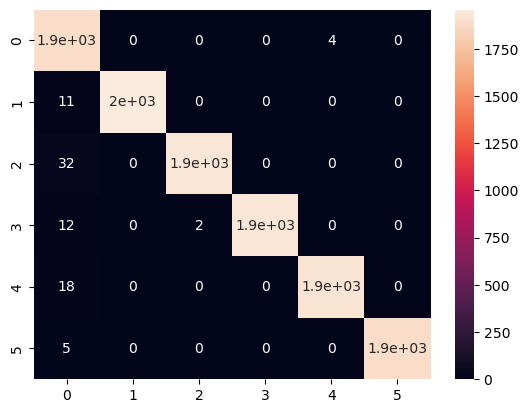

In [18]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,cbar='crest')

In [61]:
pickle.dump(best_model,open('modek.pkl','wb'))
pickle.dump(inverse,open('inverse.pkl','wb'))

In [7]:
model=pickle.load(open('model.pkl','rb'))
inverse=pickle.load(open('inverse.pkl','rb'))

In [4]:
x=[[1,298.1,308.6,1551,42.8,0]]
query=np.array(x)

In [5]:
query.shape

(1, 6)

In [8]:
y=model.predict(query)

In [9]:
pd.Series(y).map(inverse)

0    No Failure
dtype: object